# Analysis of CLS and no-filter images

The goal is to find the absorption coefficients of the CLS filter in each one of the RGB bands. From those, determined separately for the sky background and for typical stars, one can derive the increase in contrast (if any) resulting from the use of the CLS filter.

This of course applies to stars only. It remains to be seen how such filter benefits imaging of nebulae. One should expect it to be much better in that type of photography.

## Data

The data consists of 12 exposures with CLS filter, and 7 without filter, of the area around Polaris. Since the camera was kept fixed on a tripod, this location minimizes star movement in between successive frames.

The exposure time was kept constant at 30 s, but both ISO and fstop were varied in between exposures in order to sample a higer dynamic range.

No dark or flat field frames were taken, since they won't be necessary in this kind of study (see dark and flat analysis in other notebooks).

## Method

- 1) Compute exposure normalization factor for each image.
- 2) Pick two stars. Define the (square) subimage where they sit. Pick a nearby sky region of the same size, close to each star.
    - It turns out that Polaris is saturated. Two fainter stars nearby were chosen.
- 3) Plot RGB debayered and scaled version of each subimage. 
- 4) Find saturated pixels in raw subimages.
    - This can be done either by numerical search, or by plotting the raw arrays and looking at the Y scale.
- 5) Iterate 2-4 above, until image sets with no saturation, and clear background boxes, are found. 
- 6) Photometry and analysis:
    - Compute statistics in each box.
    - Compute contrast factor for each color band and star, based on statistics.

In [1]:
%pylab notebook
%matplotlib notebook

import os, glob

import multiprocessing as mp
from multiprocessing import Pool

import photutils
from astropy.table import Column

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import exifread
import rawpy
from astropy.table import Table

Populating the interactive namespace from numpy and matplotlib


## Utility functions

Complicated processing that has to be done repeatedly over lists of images, regions in the sky, and color bands, was refactored into the functions below.

In [2]:
# Extracts exposure EXIF data from a list of images

def get_metadata(filelist):

    table = Table(names=('ISO', 'Time', 'f/stop', 'Exposure', 'File'), 
                  dtype=('f4','f4','f4','f4','S2'))
    
    for filename in filelist:
        f = open(filename, 'rb')
        tags = exifread.process_file(f)
        iso = ''
        exptime = ''
        for tag in tags.keys():
            if tag in ['EXIF ExposureTime']:
                exptime = tags[tag]
            if tag in ['EXIF ISOSpeedRatings']:
                iso = tags[tag]

        index = filename.split('_')[-1].rfind('.')
        fstop = float(filename.split('_')[-1][:index][1:])
        iso = float(str(iso))
        exptime = float(str(exptime))
        
        exposure = 1./(exptime/3.2) / (iso/100) * (fstop/2.8)**2
        
        table.add_row((iso, exptime, fstop, exposure, filename))
        
    return table

In [3]:
# Functions to support running rawpy's postprocess in multiprocessor pool

# Worker function that is executed by the multioprocessor pool.
def _run_postprocess(index, filename):

    raw = rawpy.imread(filename)

    # These settings preserve the raw pixel values into the output RGB array.
    rgb = raw.postprocess(
        demosaic_algorithm=rawpy.DemosaicAlgorithm.LINEAR,
        output_bps=16,
        gamma=(1,1), 
        use_camera_wb=False,
        use_auto_wb=False,
        no_auto_bright=True, 
        no_auto_scale=True,
        output_color=rawpy.ColorSpace.raw
    )
    return index, rgb

# Postprocesses all raw files in list
def postprocess(filelist):

    # Build output list with RGB images
    temp_list = []

    # Callback to collect results from workers
    def collect_result(result):
        temp_list.append(result)
        
    # Run multiprocessor pool.
    results = []
    pool = Pool(mp.cpu_count() - 1)

    print("Start multiprocessor pool")
    for index, filename in enumerate(filelist):
        r = pool.apply_async(_run_postprocess, (index,filename,), callback=collect_result)
        results.append(r)
    for r in results:
        r.wait()
    print("End multiprocessor pool")
    
    # Sort results in the same sequence as the input file names sequence, 
    # using the indices passed to and returned by the workers.  
    output_rgb_list = [i for i in range(len(filelist))]
    for (index, rgb) in temp_list:
        output_rgb_list[index] = rgb
        
    return output_rgb_list

In [4]:
# Re-centers photometry box on star
def recenter_box(image, sx, sy):
    
    subarray = image[sy,sx,1] # use G band to find peak
    
    table = photutils.detection.find_peaks(subarray, 0., npeaks=1)
    
    peak_x = table['x_peak'][0]
    peak_y = table['y_peak'][0]

    subarray_center_x = int(subarray.shape[0] / 2)
    subarray_center_y = int(subarray.shape[1] / 2)

    new_center_x = peak_x - subarray_center_x + sx.start + int(subarray.shape[0]/2)
    new_center_y = peak_y - subarray_center_y + sy.start + int(subarray.shape[1]/2)

    slice_x = slice(new_center_x - int(subarray.shape[0]/2), new_center_x + int(subarray.shape[0]/2))
    slice_y = slice(new_center_y - int(subarray.shape[1]/2), new_center_y + int(subarray.shape[1]/2))

    return slice_x, slice_y

In [5]:
# Plots mosaic with all images from a list

colors = {'R':0,'G':1,'B':2}

def view_summary(rgblist, filelist, slicex, slicey, color, title, recenter=True, nrows=3, ncols=4):

    # Get exposure factors from image metadata
    table = get_metadata(filelist)
    
    fig = plt.figure(figsize=[9, 8])
    ax = None

    for i, filename in enumerate(filelist):
        ftitle = filename.split('/')[-1]

        sx = slicex
        sy = slicey
        if recenter:
            sx, sy = recenter_box(rgblist[i], slicex, slicey)
        rgb = rgblist[i][sy,sx,::]
        rgb = rgb * table['Exposure'][i]
    
        if ax is None:
            ax = fig.add_subplot(nrows, ncols, i+1)
            ax.set_title(ftitle)
        else:
            ax1 = fig.add_subplot(nrows, ncols, i+1, sharex=ax, sharey=ax)
            ax1.set_title(ftitle)

        plt.imshow(rgb[::,::,colors[color]]) 
        plt.colorbar()

    fig.suptitle(title)
    plt.show()

In [6]:
# Performs photometry on RGB images by integrating over boxes.

def photometry(rgblist, table, star, sec_x, sec_y, bx, by):
    # First, recenter each box on each image
    slices = [recenter_box(rgb, sec_x, sec_y) for rgb in rgblist]

    for color in colors:
        
        # Star photometry - start by ntegrating in recentered box
        values = [np.sum(rgb[sl[0],sl[1],colors[color]]) for rgb, sl in zip(rgblist, slices)]
        c = Column(values, name='Star', dtype=float32)
        table.add_column(c)
        # background doesn't have to be recentered
        c = Column([np.sum(rgb[by,bx,colors[color]]) for rgb in rgblist], name='Bkg', dtype=float32)
        table.add_column(c)
        # Subtract background and scale by exposure factor
        table[color+str(star)]  = table['Star'] - table['Bkg']
        table[color+str(star)]  = table[color+str(star)] * table['Exposure']
        table[color+str(star)].format = "%6.1f"
        table.remove_columns(['Star', 'Bkg'])

        # Background photometry
        c = Column([np.mean(rgb[by,bx,colors[color]]) for rgb in rgblist], name=color+str(star)+'bk', 
                   format="%6.1f", dtype=float32)
        table.add_column(c)
        table[color+str(star)+'bk'] = table[color+str(star)+'bk'] * table['Exposure']


    
    
    
#     c = Column([np.mean(rgb[by,bx,colors['R']]) for rgb in rgblist], name='R'+str(star)+'bk', 
#                format="%6.1f", dtype=float32)
#     table.add_column(c)
#     table['R'+str(star)+'bk'] = table['R'+str(star)+'bk'] * table['Exposure']

#     # G background
#     c = Column([np.mean(rgb[by,bx,colors['G']]) for rgb in rgblist], name='G'+str(star)+'bk', 
#                format="%6.1f", dtype=float32)
#     table.add_column(c)
#     table['G'+str(star)+'bk'] = table['G'+str(star)+'bk'] * table['Exposure']

#     # B background
#     c = Column([np.mean(rgb[by,bx,colors['B']]) for rgb in rgblist], name='B'+str(star)+'bk', 
#                format="%6.1f", dtype=float32)
#     table.add_column(c)
#     table['B'+str(star)+'bk'] = table['B'+str(star)+'bk'] * table['Exposure']

    return table

## Relevant paths for the exposures with and without filter

In [7]:
basepath = '../astrophotography_data/cls/'
without_filter_path = os.path.join(basepath,'without_filter')
with_filter_path = os.path.join(basepath,'with_filter')

list_files_without_filter = glob.glob(without_filter_path + '/*.ARW')
list_files_with_filter = glob.glob(with_filter_path + '/*.ARW')

## Plot of general area around Polaris

<IPython.core.display.Javascript object>


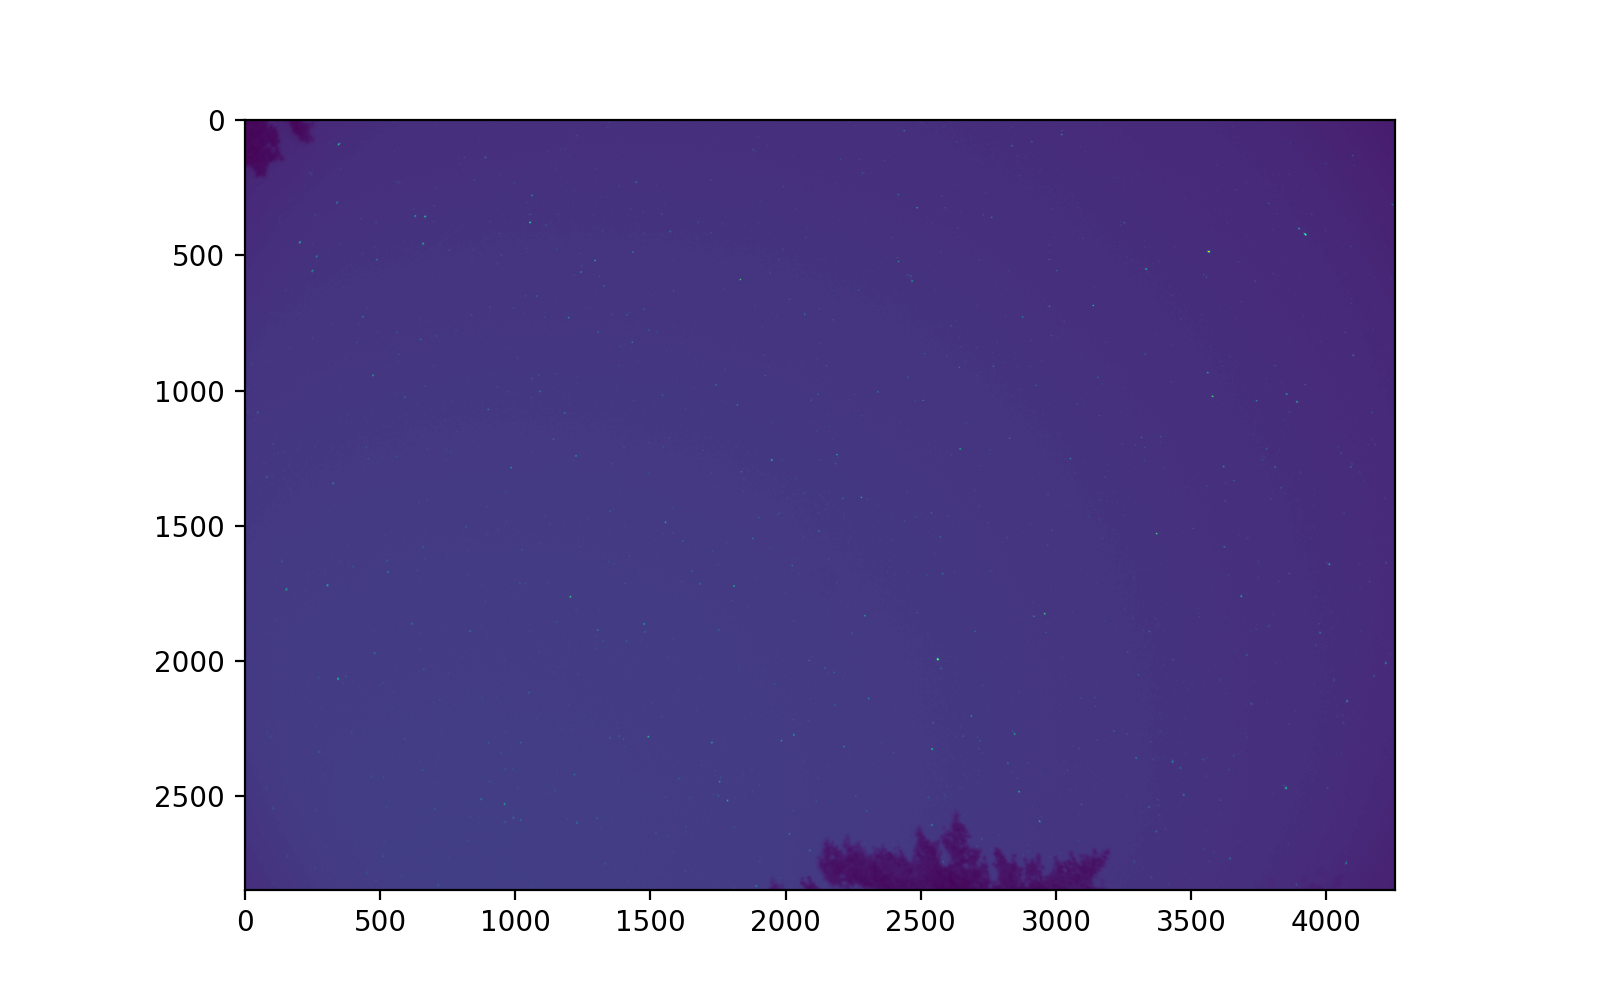

In [8]:
raw = rawpy.imread(list_files_without_filter[-1])
plt.figure(figsize=[8, 5])
plt.imshow(raw.raw_image_visible)

## Extract EXIF

From exposure metadata, compute exposure factor. Multiplying each image by the corresponding factor brings all images to the same relative scale. So they can be compared visually and photometrically.

In [9]:
table_filter = get_metadata(list_files_with_filter)
table_nofilter = get_metadata(list_files_without_filter)
table_filter.pprint_all()
table_nofilter.pprint_all()

 ISO   Time f/stop   Exposure                             File                         
------ ---- ------ ------------ -------------------------------------------------------
 400.0 30.0    4.0  0.054421768    ../astrophotography_data/cls/with_filter/I400_f4.ARW
 400.0 30.0    2.0  0.013605442    ../astrophotography_data/cls/with_filter/I400_f2.ARW
 800.0 30.0    2.8  0.013333334  ../astrophotography_data/cls/with_filter/I800_f2.8.ARW
 200.0 30.0    2.0  0.027210884    ../astrophotography_data/cls/with_filter/I200_f2.ARW
 200.0 30.0    2.8  0.053333335  ../astrophotography_data/cls/with_filter/I200_f2.8.ARW
1600.0 30.0    4.0  0.013605442   ../astrophotography_data/cls/with_filter/I1600_f4.ARW
 800.0 30.0    2.0  0.006802721    ../astrophotography_data/cls/with_filter/I800_f2.ARW
 200.0 30.0    4.0  0.108843535    ../astrophotography_data/cls/with_filter/I200_f4.ARW
1600.0 30.0    2.0 0.0034013605   ../astrophotography_data/cls/with_filter/I1600_f2.ARW
 800.0 30.0    4.0  0.027210884 

## Build RGB images

In [10]:
rgblist_filter = postprocess(list_files_with_filter)
rgblist_no_filter = postprocess(list_files_without_filter)

Start multiprocessor pool
End multiprocessor pool
Start multiprocessor pool
End multiprocessor pool


## Isolate regions of interest

In [11]:
# half-size of box
HSIZE = 10

# Main region (plot)
ry = slice(1800,2220)
rx = slice(2340,2760)

# Bright star (Polaris)  -  SATURATED
S0X = 2561
S0Y = 1994
s0y = slice(S0Y-HSIZE, S0Y+HSIZE)
s0x = slice(S0X-HSIZE, S0X+HSIZE)

# Faint star 1
# S1X = 2678
# S1Y = 2204
S1X = 2698
S1Y = 1890
s1y = slice(S1Y-HSIZE, S1Y+HSIZE)
s1x = slice(S1X-HSIZE, S1X+HSIZE)

# Background 1
B1X = int(S1X+3*HSIZE)
B1Y = int(S1Y+0.5*HSIZE)
b1y = slice(B1Y-HSIZE, B1Y+HSIZE)
b1x = slice(B1X-HSIZE, B1X+HSIZE)

# Faint star 2  -  TOO FAINT
# S2X = 2567
# S2Y = 2029
# s2y = slice(S2Y-HSIZE, S2Y+HSIZE)
# s2x = slice(S2X-HSIZE, S2X+HSIZE)

# Faint star 2  -  TOO FAINT
# S2X = 2340+358
# S2Y = 1800+95
# s2y = slice(S2Y-HSIZE, S2Y+HSIZE)
# s2x = slice(S2X-HSIZE, S2X+HSIZE)

# Faint star 2
S2X = 2570
S2Y = 2027
s2y = slice(S2Y-HSIZE, S2Y+HSIZE)
s2x = slice(S2X-HSIZE, S2X+HSIZE)

# Background 2
B2X = int(S2X-2.3*HSIZE)
B2Y = int(S2Y+0.1*HSIZE)
b2y = slice(B2Y-HSIZE, B2Y+HSIZE)
b2x = slice(B2X-HSIZE, B2X+HSIZE)

## Display RGB images

Use parameters to select regions to be displayed, and color band.

<IPython.core.display.Javascript object>


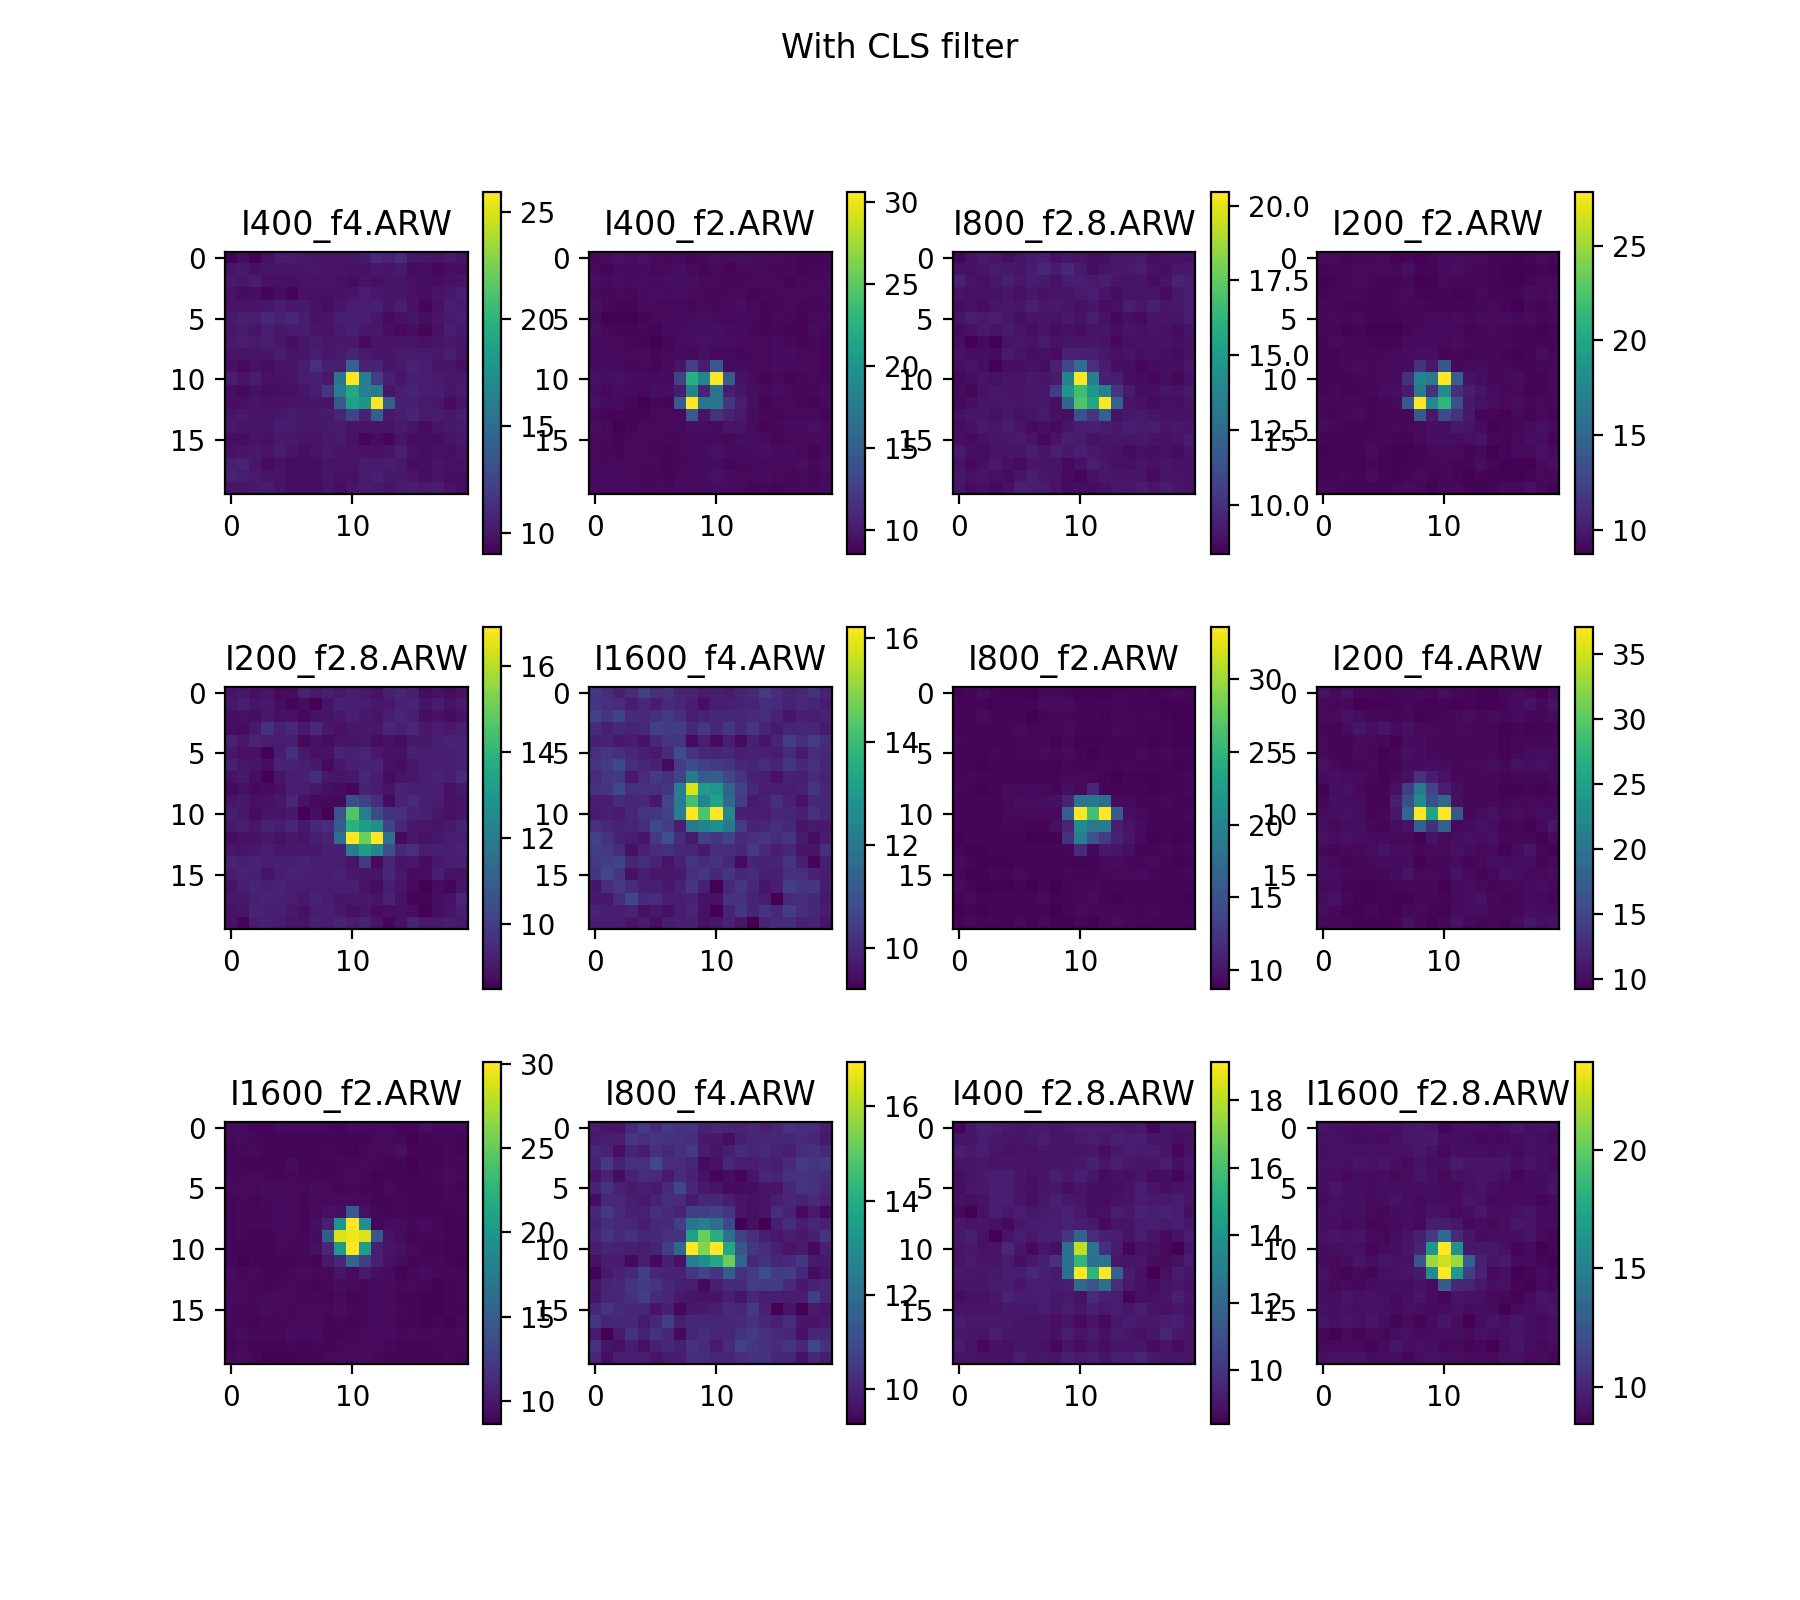

<IPython.core.display.Javascript object>


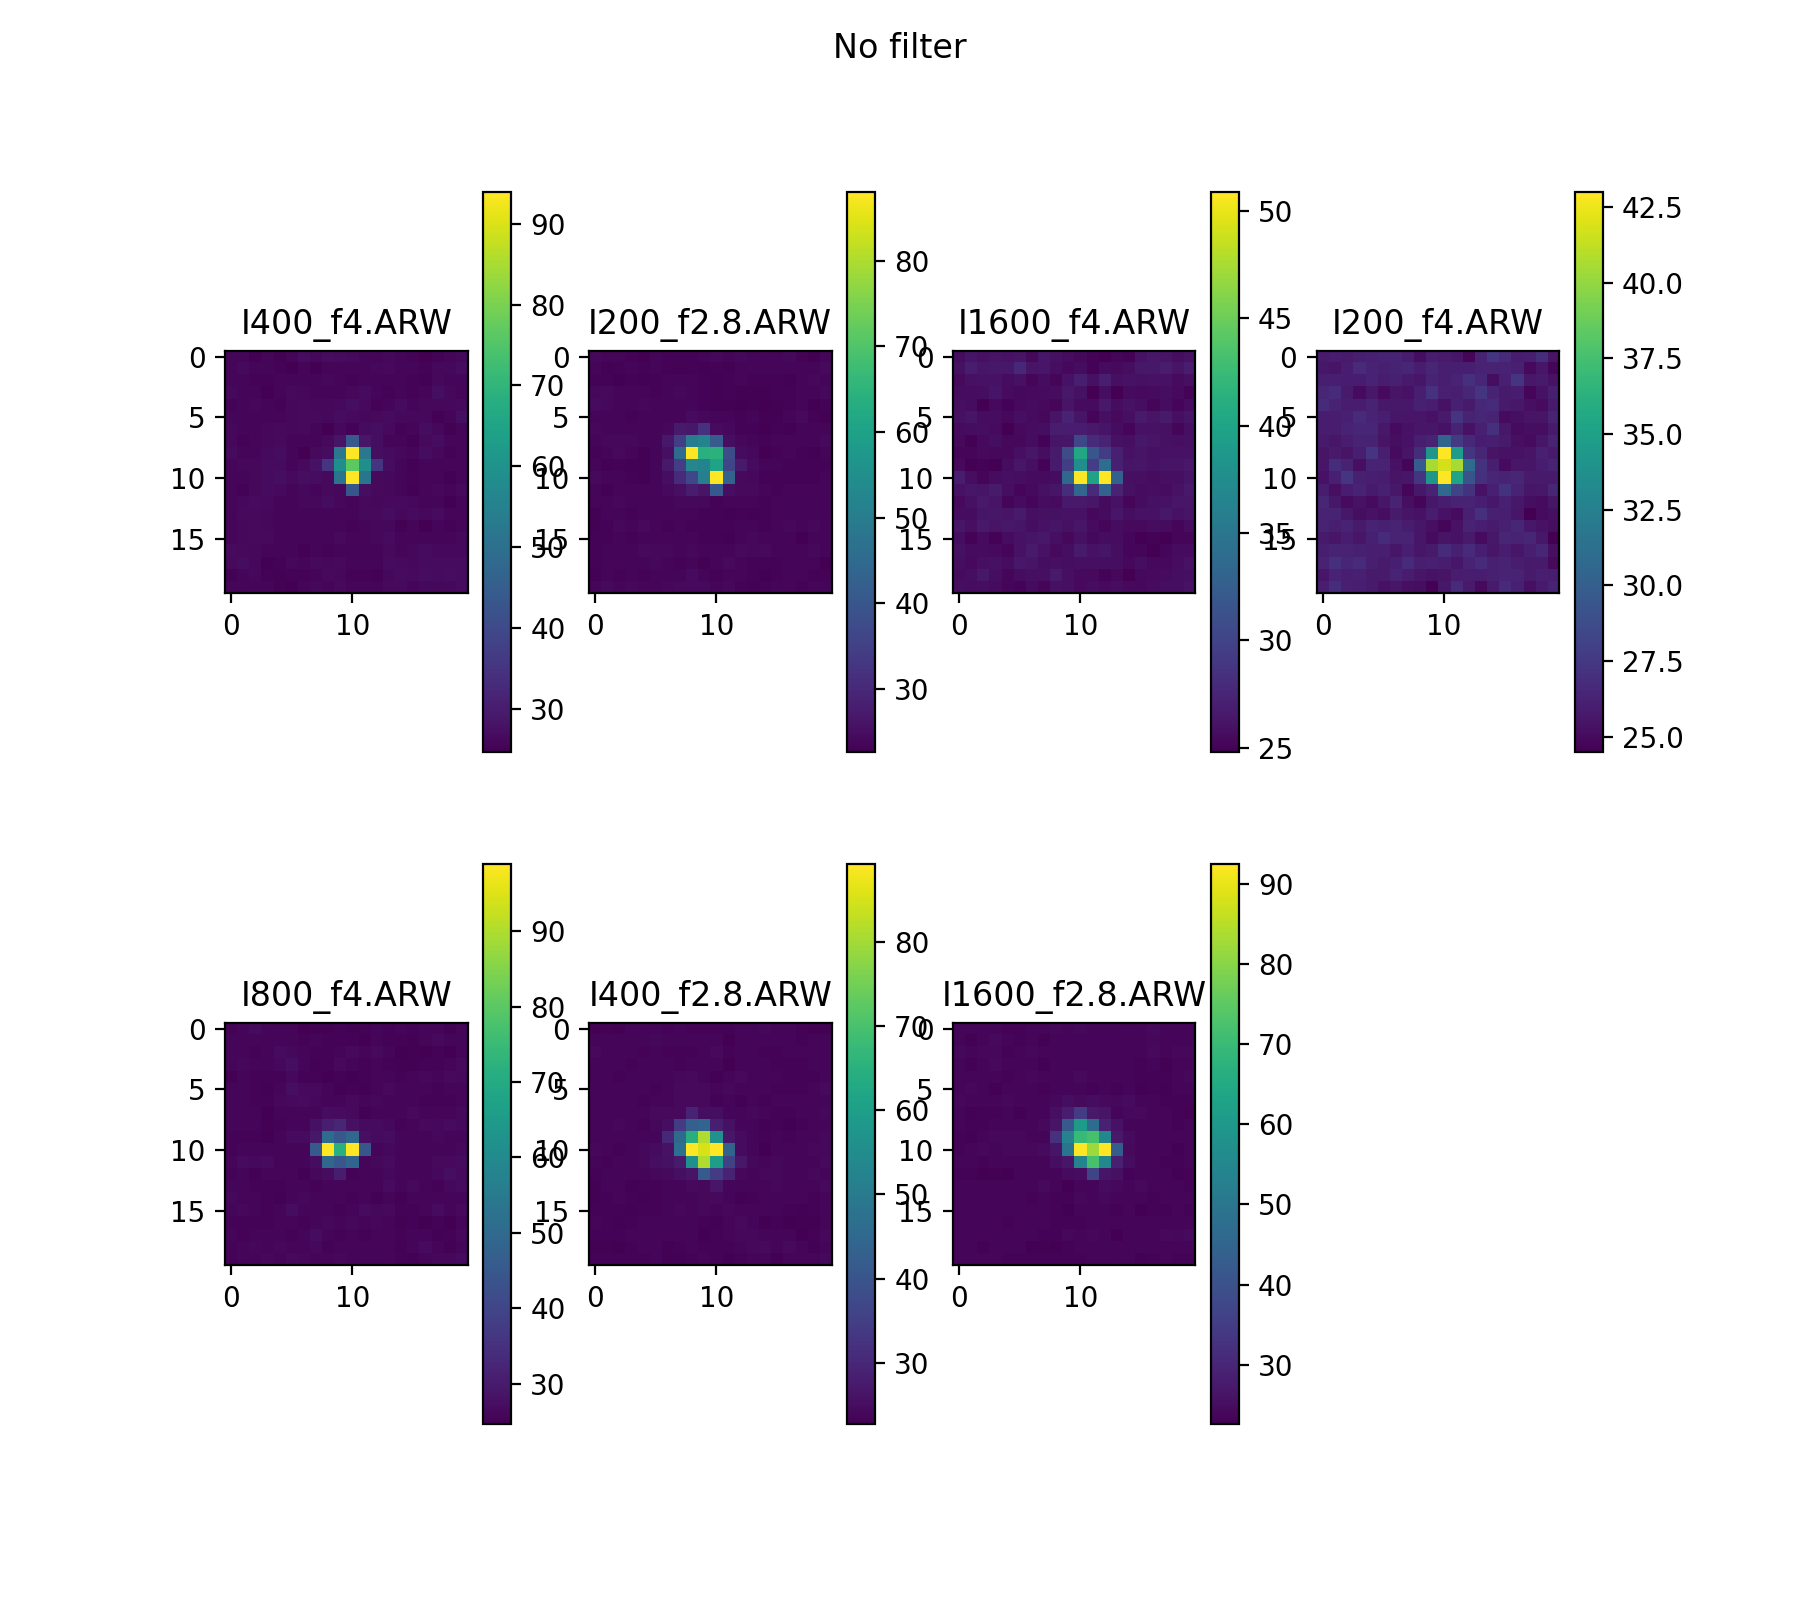

In [12]:
view_summary(rgblist_filter, list_files_with_filter, s1x, s1y, 'G', "With CLS filter", recenter=True)
view_summary(rgblist_no_filter, list_files_without_filter, s1x, s1y, 'G', "No filter", recenter=True, nrows=2)

## Photometry

In [13]:
table_filter.remove_columns(['File'])
table_nofilter.remove_columns(['File'])

In [14]:
table_filter = photometry(rgblist_filter, table_filter, 1, s1x, s1y, b1x, b1y)
table_filter = photometry(rgblist_filter, table_filter, 2, s2x, s2y, b2x, b2y)

In [15]:
table_filter.pprint_all()
table_filter.info('stats')

 ISO   Time f/stop   Exposure     R1    R1bk    G1    G1bk    B1    B1bk    R2    R2bk    G2    G2bk    B2    B2bk 
------ ---- ------ ------------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------
 400.0 30.0    4.0  0.054421768   60.4    1.7  298.9   10.0  479.1   10.3   56.9    1.8  141.7   10.2  287.0   10.6
 400.0 30.0    2.0  0.013605442   60.0    1.6  269.7    9.1  431.8   10.0   38.9    1.6  192.1    9.3  284.5   10.1
 800.0 30.0    2.8  0.013333334   59.9    1.5  303.6    9.0  397.0    9.6   51.5    1.6  165.3    9.2  253.5    9.7
 200.0 30.0    2.0  0.027210884   63.0    1.6  286.0    9.0  423.0   10.0   52.5    1.6  213.9    9.2  296.2   10.1
 200.0 30.0    2.8  0.053333335   61.3    1.6  247.4    9.0  386.9    9.6   36.3    1.6  128.4    9.3  238.9    9.8
1600.0 30.0    4.0  0.013605442   62.5    1.7  281.1   10.0  390.7   10.5   25.3    1.7  166.6   10.2  269.5   10.6
 800.0 30.0    2.0  0.006802721   59.4    1.6  290.3    9.1  420.2   10.

In [16]:
table_nofilter = photometry(rgblist_no_filter, table_nofilter, 1, s1x, s1y, b1x, b1y)
table_nofilter = photometry(rgblist_no_filter, table_nofilter, 2, s2x, s2y, b2x, b2y)

In [17]:
table_nofilter.pprint_all()
table_nofilter.info('stats')

 ISO   Time f/stop   Exposure    R1    R1bk    G1    G1bk    B1    B1bk    R2    R2bk    G2    G2bk    B2    B2bk 
------ ---- ------ ----------- ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------
 400.0 30.0    4.0 0.054421768  288.6    9.7  956.1   25.8  509.9   16.6  264.3    9.8  626.6   26.3  297.3   16.8
 200.0 30.0    2.8 0.053333335  338.3    8.8 1004.1   23.5  535.1   15.2  222.8    9.0  574.0   24.0  258.6   15.5
1600.0 30.0    4.0 0.013605442  353.8    9.6  926.4   25.8  576.5   16.5  193.1    9.9  650.8   26.4  253.5   16.9
 200.0 30.0    4.0 0.108843535  341.0    9.7  948.5   25.8  505.9   16.5  225.0    9.9  605.5   26.5  293.9   16.9
 800.0 30.0    4.0 0.027210884  398.9    9.7  940.5   25.9  560.7   16.5  237.3    9.9  636.1   26.4  295.8   16.9
 400.0 30.0    2.8 0.026666667  337.6    8.8  865.4   23.6  471.9   15.2  214.3    9.0  581.8   24.0  277.9   15.5
1600.0 30.0    2.8 0.006666667  350.5    8.7  834.7   23.5  430.1   15.1  236.0 

## Contrast

Increase in contrast caused by the CLS filter can be measured by how much the signal from a star drops, compared with how much the signal of the sky drops in the same band.

In [18]:
print("R1: ", np.median(table_nofilter['R1'].data) / np.median(table_filter['R1'].data))
print("R2: ", np.median(table_nofilter['R2'].data) / np.median(table_filter['R2'].data))
print("R1bk: ", np.median(table_nofilter['R1bk'].data) / np.median(table_filter['R1bk'].data))
print("R2bk: ", np.median(table_nofilter['R2bk'].data) / np.median(table_filter['R2bk'].data))
print()
print("G1: ", np.median(table_nofilter['G1'].data) / np.median(table_filter['G1'].data))
print("G2: ", np.median(table_nofilter['G2'].data) / np.median(table_filter['G2'].data))
print("G1bk: ", np.median(table_nofilter['G1bk'].data) / np.median(table_filter['G1bk'].data))
print("G2bk: ", np.median(table_nofilter['G2bk'].data) / np.median(table_filter['G2bk'].data))
print()
print("B1: ", np.median(table_nofilter['B1'].data) / np.median(table_filter['B1'].data))
print("B2: ", np.median(table_nofilter['B2'].data) / np.median(table_filter['B2'].data))
print("B1bk: ", np.median(table_nofilter['B1bk'].data) / np.median(table_filter['B1bk'].data))
print("B2bk: ", np.median(table_nofilter['B2bk'].data) / np.median(table_filter['B2bk'].data))

R1:  5.666102
R2:  5.6178017
R1bk:  6.080364
R2bk:  6.1142435

G1:  3.2245162
G2:  3.190451
G1bk:  2.8493803
G2bk:  2.845617

B1:  1.247981
B2:  1.0548849
B1bk:  1.6539937
B2bk:  1.6625512
